# Electrode recording
How to insert electrodes to measure different spiking and extracellular signals from a Brian network simulation.

Preamble:

In [ ]:
import brian2.only as b2
from brian2 import np
import matplotlib.pyplot as plt
import cleo
import cleo.utilities

# the default cython compilation target isn't worth it for
# this trivial example
b2.prefs.codegen.target = "numpy"
seed = 18810929
b2.seed(seed)
np.random.seed(seed)
cleo.utilities.set_seed(seed)

cleo.utilities.style_plots_for_docs()

# colors
c = {
    "light": "#df87e1",
    "main": "#C500CC",
    "dark": "#8000B4",
    "exc": "#d6755e",
    "inh": "#056eee",
    "accent": "#36827F",
}

<!-- so we don't have to type full name in references -->
```{currentmodule} cleo.ephys
```

## Network setup
First we create a simple E-I network with external Poisson input and assign coordinates.
We only need spiking neurons to record {class}`TKLFPSignal`, but we need synapses onto pyramidal cells for {class}`RWSLFPSignalFromSpikes`.

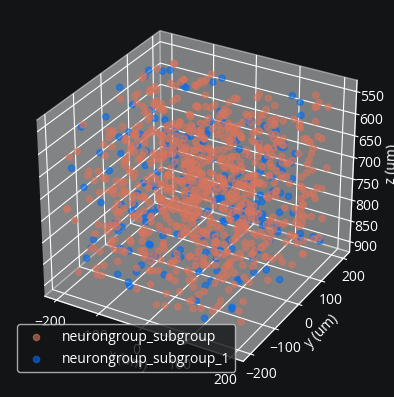

In [ ]:
N = 1000
n_e = int(N * 0.8)
n_i = int(N * 0.2)
n_ext = 500

neurons = b2.NeuronGroup(
    N,
    "dv/dt = -v / (10*ms) : 1",
    threshold="v > 1",
    reset="v = 0",
    refractory=2 * b2.ms,
)
ext_input = b2.PoissonGroup(n_ext, 24 * b2.Hz, name="ext_input")
cleo.coords.assign_coords_rand_rect_prism(
    neurons, xlim=(-0.2, 0.2), ylim=(-0.2, 0.2), zlim=(0.55, 0.9)
)
# need to create subgroups after assigning coordinates
exc = neurons[:n_e]
inh = neurons[n_e:]

w0 = 0.06
syn_exc = b2.Synapses(
    exc,
    neurons,
    f"w = {w0} : 1",
    on_pre="v_post += w",
    name="syn_exc",
    delay=1.5 * b2.ms,
)
syn_exc.connect(p=0.1)
syn_inh = b2.Synapses(
    inh,
    neurons,
    f"w = -4*{w0} : 1",
    on_pre="v_post += w",
    name="syn_inh",
    delay=1.5 * b2.ms,
)
syn_inh.connect(p=0.1)
syn_ext = b2.Synapses(
    ext_input, neurons, "w = .05 : 1", on_pre="v_post += w", name="syn_ext"
)
syn_ext.connect(p=0.1)

# we'll monitor all spikes to compare with what we get on the electrode
spike_mon = b2.SpikeMonitor(neurons)

net = b2.Network([neurons, exc, inh, syn_exc, syn_inh, ext_input, syn_ext, spike_mon])
sim = cleo.CLSimulator(net)
cleo.viz.plot(exc, inh, colors=[c["exc"], c["inh"]], scatterargs={"alpha": 0.6});

## Specifying electrode coordinates

Now we insert an electrode shank probe in the center of the population by injecting a {class}`Probe` device.
Note that {class}`Probe` takes arbitrary coordinates as arguments, so you can place contacts wherever you wish.
However, the {mod}`cleo.ephys` module provides convenience functions to easily generate coordinates common in [NeuroNexus probes](https://www.neuronexus.com/products/electrode-arrays/).
Here are some examples:

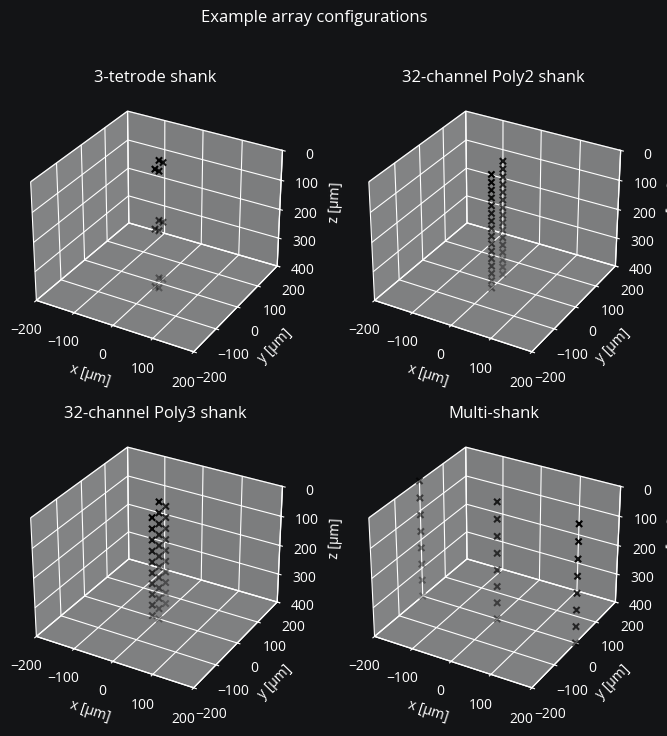

In [ ]:
from cleo import ephys
from mpl_toolkits.mplot3d import Axes3D

array_length = 0.4 * b2.mm  # length of the array itself, not the shank
tetr_coords = ephys.tetrode_shank_coords(array_length, tetrode_count=3)
poly2_coords = ephys.poly2_shank_coords(
    array_length, channel_count=32, intercol_space=50 * b2.um
)
poly3_coords = ephys.poly3_shank_coords(
    array_length, channel_count=32, intercol_space=30 * b2.um
)
# by default start_location (location of first contact) is at (0, 0, 0)
single_shank = ephys.linear_shank_coords(
    array_length, channel_count=8, start_location=(-0.2, 0, 0) * b2.mm
)
# tile vector determines length and direction of tiling (repeating)
multishank = ephys.tile_coords(
    single_shank, num_tiles=3, tile_vector=(0.4, 0, 0) * b2.mm
)

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Example array configurations")
for i, (coords, title) in enumerate(
    [
        (tetr_coords, "3-tetrode shank"),
        (poly2_coords, "32-channel Poly2 shank"),
        (poly3_coords, "32-channel Poly3 shank"),
        (multishank, "Multi-shank"),
    ],
    start=1,
):
    ax = fig.add_subplot(2, 2, i, projection="3d")
    x, y, z = coords.T / b2.um
    ax.scatter(x, y, z, marker="x", c="black")
    ax.set(
        title=title,
        xlabel="x [μm]",
        ylabel="y [μm]",
        zlabel="z [μm]",
        xlim=(-200, 200),
        ylim=(-200, 200),
        zlim=(400, 0),
    )

As seen above, the {func}`tile_coords` function can be used to repeat a single shank to produce coordinates for a multi-shank probe. Likewise it can be used to repeat multi-shank coordinates to achieve a 3D recording array (what NeuroNexus calls a [MatrixArray](https://www.neuronexus.com/products/electrode-arrays/3D-probes)).

For our example we will use a simple linear array. We configure the probe so it has 32 contacts ranging from 0.2 to 1.2 mm in depth. We could specify the orientation, but by default shank coordinates extend downwards (in the positive z direction).

We can add the electrode to the plotting function to visualize it along with the neurons:

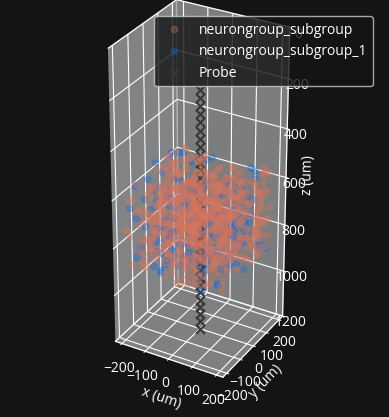

In [ ]:
coords = ephys.linear_shank_coords(1 * b2.mm, 32, start_location=(0, 0, 0.2) * b2.mm)
probe = ephys.Probe(coords, save_history=True)
cleo.viz.plot(
    exc,
    inh,
    colors=[c["exc"], c["inh"]],
    zlim=(0, 1200),
    devices=[probe],
    scatterargs={"alpha": 0.3},
);

## Specifying signals to record

This looks right, but we need to specify what signals we want to pick up with our electrode.
Here we'll explain the different options for spike and LFP recording.


### {class}`SortedSpiking` and {class}`MultiUnitActivity`

Spike recording works by sampling spike amplitudes per-neuron and per-channel, incorporating both intrinsic variability and background noise, introducing stochasticity into detection.
Measurements that cross the specified detection threshold (both spikes and false positives from noise) are sent through a collision sampling process, where close-by spikes on a given channel are further thinned out.
{class}`SortedSpiking` reports a spike (with an index uniquely and correctly identifying the source neuron) if detected on at least one channel and throws out false positives.
{class}`MultiUnitActivity` simply reports spikes by channel and time, including false positives.

Both spiking signals (sorted and multi-unit) take the same main parameters, the most relevant ones being:
- {attr}`~Spiking.r_noise_floor`: the radius at which the average extracellular action potential amplitude and the noise standard deviation are equal, i.e., $A(r_\text{noise floor}) = \sigma_\text{noise}=1$.
    - The default is 80 μm—increase for cleaner or decrease for noisier recordings.
- {attr}`~Spiking.threshold_sigma`: the threshold above which an extracellular potential is classified as an action potential, as a multiple of $\sigma_\text{noise}$.
    - The default is 4. Values in real experiments typically range from 3 to 6.
- {attr}`~Spiking.spike_amplitude_cv`: The coefficient of variation of spike amplitudes, i.e., $\sigma_A/\mu_A$.
    - By default 0.05. Typical values for real cells lie between 0 and 0.2, inhibitory cells tending to be higher.
- {attr}`~Spiking.eap_decay_fn`: a function defining how the extracellular action potential amplitude decays with distance.
    - By default $1/r^2$. [Pettersen et al. (2008)](https://www.cell.com/biophysj/fulltext/S0006-3495(08)70679-9) find this varies between $1/r^2$ and $1/r^3$ depending on cell type on distance.
- {attr}`~Spiking.collision_prob_fn`: a function (of time) defining how likely spikes are to "collide," where closely occurring spikes on a given channel lead to one not being counted.
    - The default for {class}`~SortedSpiking` is $0.2\exp(-t/(3\,\text{ms}))$, reflecting that sorters can often distinguish simultaneous spikes.
    - The default for {class}`~MultiUnitActivity` is $t < 1\,\text{ms}$, reflecting the common practice of enforcing a hard refractory period in multi-unit activity, not counting a threshold crossing soon after a previous one.
    - In the case of a collision, Cleo simply keeps the first spike, or the spike with the larger measured amplitude if they are simultaneous.

See `notebooks/spike_detection` in the source repo for more detail on these parameters.
{class}`SortedSpiking` also provides an {attr}`~SortedSpiking.snr_cutoff` parameter determining the minimum signal-to-noise ratio a unit must have for its spikes to be sorted/reported.

Here we just use the defaults:

In [ ]:
mua = ephys.MultiUnitActivity()
ss = ephys.SortedSpiking()

### LFP approximations
Biophysical, forward modeling of LFP requires multi-compartment models.
To leverage the agility of point neuron models, we have implemented two simplified LFP proxy methods from the literature.

The [Teleńczuk kernel LFP approximation method (TKLFP)](https://www.sciencedirect.com/science/article/pii/S0165027020302946) models LFP as the sum of per-spike contributions, which take the form of a Gaussian kernel scaled and shifted by location relative to the electrode.
We use default parameters here.
Note we will need to specify cell type (excitatory or inhibitory) and sampling period (if unavailable from a connected IO processor) upon injection.

The [reference weighted sum of synaptic currents LFP proxy (RWSLFP)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004584), on the other hand, takes synaptic currents rather than spikes directly. 
If you model these postsynaptic currents (PSCs) explicitly in your model, use {class}`RWSLFPSignalFromPSCs`.
If not, and this is the case here, Cleo can still accommodate simpler models by synthesizing PSCs for you, convolving spikes with a biexponential kernel.
For that, we use {class}`RWSLFPSignalFromSpikes` and pass in `ampa_syns` and `gaba_syns` on injection to compute the effect of incoming spikes on the population we're recording from.
We only need to do this for pyramidal cells, since RWSLFP ignores currents onto interneurons.

In [ ]:
tklfp = ephys.TKLFPSignal()
rwslfp = ephys.RWSLFPSignalFromSpikes()

probe.add_signals(mua, ss, tklfp, rwslfp)

sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period=1 * b2.ms))
sim.inject(
    probe,
    exc,
    tklfp_type="exc",
    ampa_syns=[syn_exc[f"j < {n_e}"], syn_ext[f"j < {n_e}"]],
    gaba_syns=[syn_inh[f"j < {n_e}"]],
)
sim.inject(probe, inh, tklfp_type="inh")

CLSimulator(io_processor=RecordOnlyProcessor(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={Probe(name='Probe', save_history=True, signals=[MultiUnitActivity(name='MultiUnitActivity', probe=..., r_noise_floor=80. * umetre, threshold_sigma=4, spike_amplitude_cv=0.05, r0=5. * umetre, recording_recall_cutoff=0.001, eap_decay_fn=<function Spiking.<lambda>>, simulate_false_positives=True, collision_prob_fn=<function MultiUnitActivity.<lambda>>), SortedSpiking(name='SortedSpiking', probe=..., r_noise_floor=80. * umetre, threshold_sigma=4, spike_amplitude_cv=0.05, r0=5. * umetre, recording_recall_cutoff=0.001, eap_decay_fn=<function Spiking.<lambda>>, simulate_false_positives=True, snr_cutoff=6, collision_prob_fn=<function SortedSpiking.<lambda>>), TKLFPSignal(name='TKLFPSignal', probe=..., uLFP_threshold=1. * nvolt, _lfp_unit=uvolt), RWSLFPSignalFromSpikes(name='RWSLFPSignalFromSpikes', probe=..., amp_func=<function mazzoni15_nrn>, pop_aggregate=False, wslfp_k

## Simulation and results

Now we'll run the simulation:

In [ ]:
sim.run(250 * b2.ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.26s). [brian2.stateupdaters.base.method_choice]


And plot the output of the four signals we've recorded.
We'll compare our recorded spikes to the ground truth for reference:

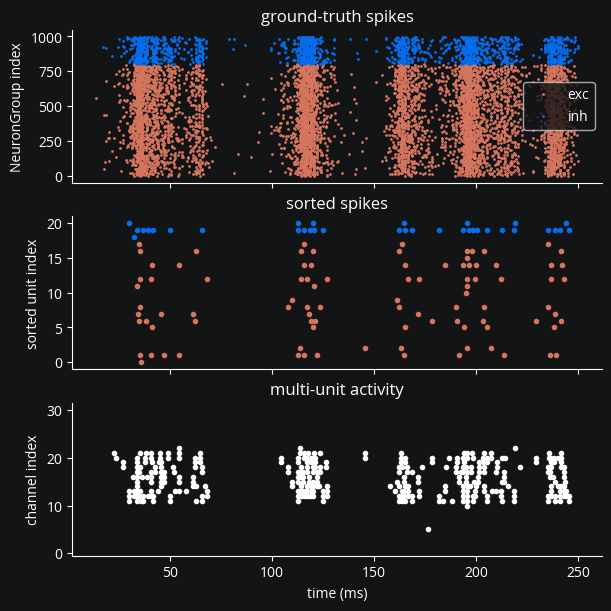

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, layout="constrained", figsize=(6, 6))

spikes_are_exc = spike_mon.i < n_e
# need to map sorted unit index to cell type
i_sorted_is_exc = np.array([ng == exc for (ng, i) in ss.i_ng_by_i_sorted])
sorted_spikes_are_exc = i_sorted_is_exc[ss.i]

for celltype, i_all, i_srt in [
    ("exc", spikes_are_exc, sorted_spikes_are_exc),
    ("inh", ~spikes_are_exc, ~sorted_spikes_are_exc),
]:
    axs[0].plot(
        spike_mon.t[i_all] / b2.ms,
        spike_mon.i[i_all],
        ".",
        c=c[celltype],
        rasterized=True,
        label=celltype,
        ms=2,
    )
    axs[1].plot(
        ss.t[i_srt] / b2.ms,
        ss.i[i_srt],
        ".",
        c=c[celltype],
        label=celltype,
        rasterized=True,
    )
axs[0].legend()
axs[0].set(ylabel="NeuronGroup index", title="ground-truth spikes")
axs[1].set(title="sorted spikes", ylabel="sorted unit index")

axs[2].plot(mua.t / b2.ms, mua.i, "w.", rasterized=True)
axs[2].set(
    title="multi-unit activity",
    ylabel="channel index",
    xlabel="time (ms)",
    ylim=[-0.5, probe.n - 0.5],
);

TKLFP supposedly outputs a value with an absolute scale in terms of μV, though it is quite high compared to $\pm0.1$ μV scale of RWSLFP as given in Mazzoni, Lindén et al., 2015.
RWSLFP outputs unnormalized LFP instead of this $\pm0.1$ μV range to sidestep the complications of normalizing in a causal, stepwise manner.

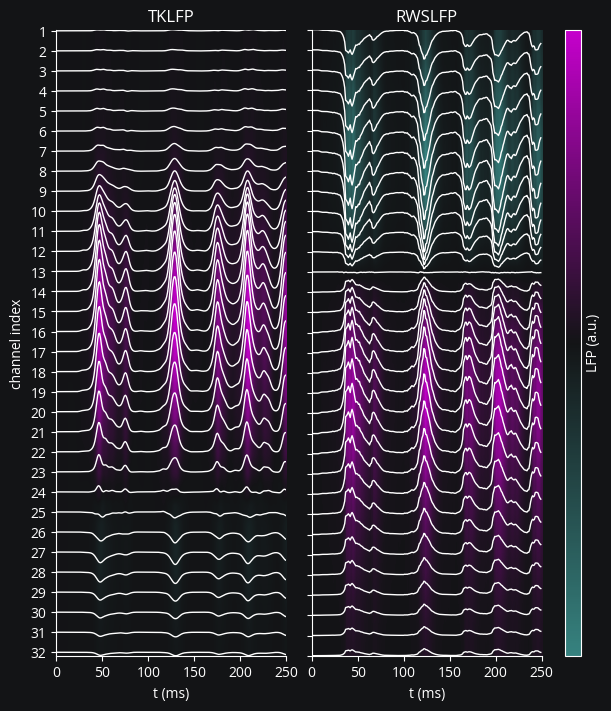

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

fig, axs = plt.subplots(1, 2, figsize=(6, 7), sharey=False, layout="constrained")
for ax, lfp, title in [
    (axs[0], tklfp.lfp / b2.uvolt, "TKLFP"),
    (axs[1], rwslfp.lfp, "RWSLFP"),
]:
    channel_offsets = -np.abs(np.quantile(lfp, 0.9)) * np.arange(probe.n)
    lfp2plot = lfp + channel_offsets
    ax.plot(lfp2plot, color="white", lw=1)
    ax.set(
        yticks=channel_offsets,
        xlabel="t (ms)",
        title=title,
    )

    extent = (0, 250, lfp2plot.min(), lfp2plot.max())
    cmap = LinearSegmentedColormap.from_list("lfp", [c["accent"], "#131416", c["main"]])
    im = ax.imshow(
        lfp.T,
        aspect="auto",
        cmap=cmap,
        extent=extent,
        vmin=-np.max(np.abs(lfp)),
        vmax=np.max(np.abs(lfp)),
    )

fig.colorbar(im, aspect=40, label="LFP (a.u.)", ticks=[])

axs[0].set(
    ylabel="channel index",
    yticklabels=range(1, 33),
)
axs[1].set(yticklabels=[]);

See {doc}`advanced_lfp` for more options and comparison of different LFP signals.